# 🛍️ Exploratory Data Analysis (EDA): Brazilian Retail Dataset

This notebook performs an exploratory and predictive analysis on a **Brazilian retail time series dataset**. The dataset contains daily records of:

- `venda`: Number of units sold (sales volume)  
- `estoque`: Inventory level (stock on hand)  
- `preco`: Unit price  
- `data`: Date of observation  

Throughout this notebook, we:

1. Analyze basic patterns and trends in daily and monthly sales.
2. Visualize long-term trends, seasonal cycles, and irregular shocks using techniques like **STL decomposition**.
3. Check for missing values and potential anomalies in the data.
4. Build **forecasting models**, including:
   - **ARIMA** for univariate time series forecasting
   - **STL + ARIMA** for decomposed forecasting
   - **VAR (Vector Autoregression)** to jointly model and forecast multiple variables (e.g., sales, price, stock)

This analysis provides both descriptive insights and predictive modeling results, with the goal of supporting inventory planning, price adjustment, and demand forecasting.

📌 **Data Source**:  
The dataset is publicly available on [Kaggle](https://www.kaggle.com/datasets/ritsaopaulo/brazilian-retail-dataset) and contains real-world retail sales records collected over multiple years in Brazil. It includes detailed information on product-level sales, inventory, and pricing, making it well-suited for time series analysis and forecasting.


In [19]:
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA

In [20]:
retail = pd.read_csv("/Users/quentingao/Library/CloudStorage/OneDrive-TulaneUniversity/R_or_Python/Python_jupyternotebook/Retail/Brazilian_Retail_Data.csv")
retail.head(20)


,data,venda,estoque,preco
0,2014-01-01,0,4972,1.29
1,2014-01-02,70,4902,1.29
2,2014-01-03,59,4843,1.29
3,2014-01-04,93,4750,1.29
4,2014-01-05,96,4654,1.29
5,2014-01-06,145,4509,1.29
6,2014-01-07,179,4329,1.29
7,2014-01-08,321,4104,1.29
8,2014-01-09,125,4459,1.09
9,2014-01-10,88,5043,1.09


## 🔧 Rename Columns for Clarity

To make the dataset easier to work with, we rename the original column names (which are in Portuguese) to more intuitive English labels:

- `"data"` → `"date"`
- `"venda"` → `"sales"`
- `"estoque"` → `"stock"`
- `"preco"` → `"price"`

This improves readability and consistency throughout the analysis.

```python
retail = retail.rename(columns={
    "data": "date",
    "venda": "sales",
    "estoque": "stock",
    "preco": "price"
})


In [21]:
retail = retail.rename(columns={
    "data": "date",
    "venda": "sales",
    "estoque": "stock",
    "preco": "price"
})


In [22]:
retail['date'] = pd.to_datetime(retail['date'])
retail.set_index('date', inplace=True)

sales_ts = retail['sales']

retail.sample(20)


,sales,stock,price
date,,,
2014-10-19,119,1998,1.29
2015-08-20,25,1446,1.17
2014-11-07,82,717,1.49
2016-04-28,113,1843,2.59
2014-03-28,174,3505,1.19
2015-12-12,142,1637,2.29
2014-10-05,47,1683,1.29
2015-01-21,88,1177,1.29
2015-04-25,152,434,1.40


## 📉  Visualize Sales Trend and Check Stationarity

To begin time series modeling, it is crucial to first understand the behavior of the data over time and assess whether the series is stationary.

### 📊 Time Series Plot

We plotted the daily sales (`sales_ts`) to get a visual sense of its trend and volatility. From the figure, we can observe strong variability across time, with certain periods showing clear spikes in sales volume. However, there is **no obvious deterministic trend** or seasonality, making it a good candidate for stationarity testing.

### 🧪 ADF (Augmented Dickey-Fuller) Test for Stationarity

To formally test whether the time series is stationary, we applied the Augmented Dickey-Fuller (ADF) test.

- **ADF Test Statistic**: -5.33  
- **p-value**: < 0.00001  
- **Critical values** at common significance levels:
  - 1%: -3.43  
  - 5%: -2.86  
  - 10%: -2.57  

Because the ADF test statistic is **smaller than all critical values**, and the **p-value is well below 0.05**, we reject the null hypothesis of a unit root.

> ✅ **Conclusion**: The sales time series is stationary. We can proceed with ARIMA modeling without first differencing the data.


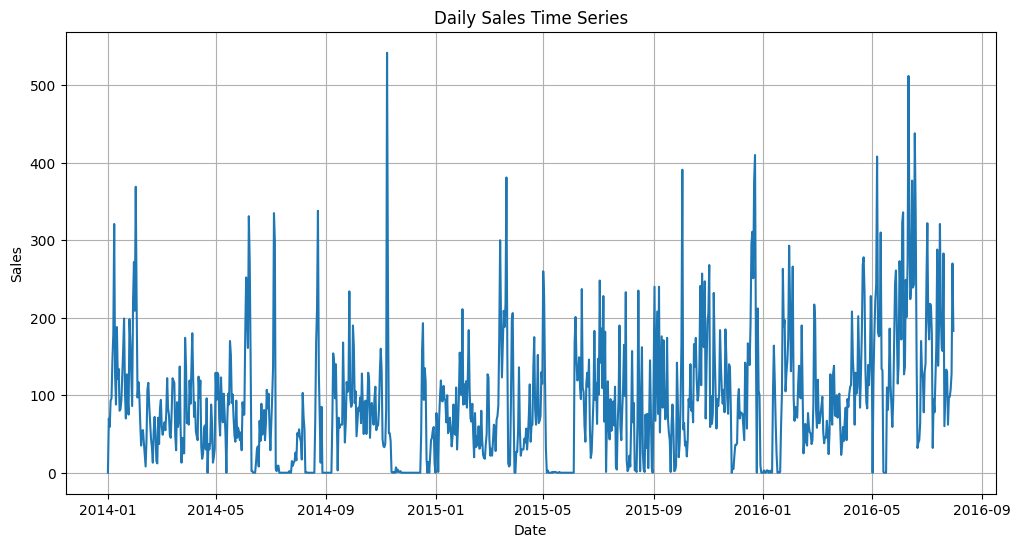

In [ ]:
# Step 2: Plot the daily sales
plt.figure(figsize=(12, 6))
plt.plot(sales_ts)
plt.title("Daily Sales Time Series")
plt.xlabel("Date")
plt.ylabel("Sales")
plt.grid(True)
plt.show()


In [17]:
# Step 3: Stationarity test
result = adfuller(sales_ts)
print("ADF Test Statistic:", result[0])
print("p-value:", result[1])
for key, value in result[4].items():
    print(f'Critical Value ({key}): {value}')


ADF Test Statistic: -5.326902281189406
p-value: 4.815089201365738e-06
Critical Value (1%): -3.437462363899248
Critical Value (5%): -2.8646798473884134
Critical Value (10%): -2.568441851017076


## 🔁 First-order Differencing and Re-checking Stationarity

Although our original ADF test already indicated stationarity, we demonstrate the standard differencing process here as a general procedure for non-stationary series.

### 🔹 Apply First-order Differencing

We compute the first-order difference of the sales series to remove potential trend or autocorrelation. This transformation helps stabilize the mean of a time series by removing changes in the level of the series.

The differenced series is then visualized below.

### 🔹 Plot Differenced Series

The plot of the differenced series shows a centered, fluctuation-stable process, which is a typical visual indicator of stationarity.

### 🔹 ADF Test on Differenced Series

We repeat the ADF test on the differenced series to statistically confirm stationarity.

- If the **p-value** remains **< 0.05**, we reject the null hypothesis of a unit root.
- A lower ADF test statistic than the critical values supports the conclusion of stationarity.

> ✅ **Conclusion**: The differenced sales series is stationary and ready for ACF/PACF analysis and ARIMA modeling.


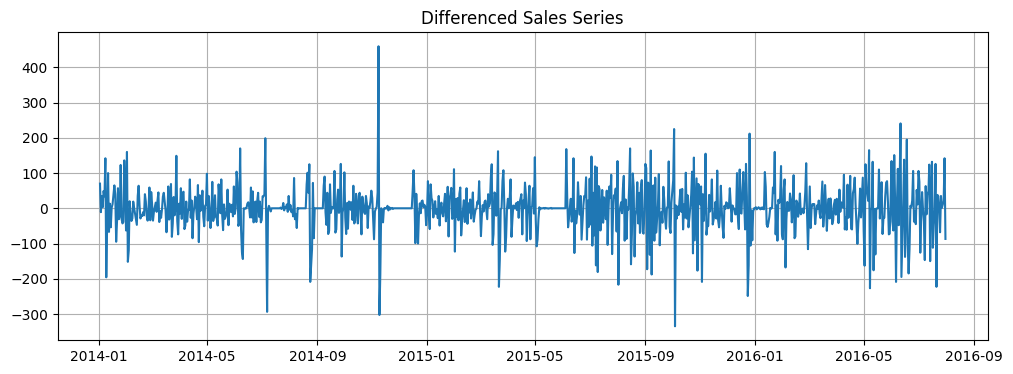

ADF Test (Differenced): -10.78655526925482
p-value: 2.1867302238476744e-19


In [8]:
# Step 4: First-order Differencing (if non-stationary)
sales_diff = sales_ts.diff().dropna()

plt.figure(figsize=(12, 4))
plt.plot(sales_diff)
plt.title("Differenced Sales Series")
plt.grid(True)
plt.show()

# ADF test, again
result_diff = adfuller(sales_diff)
print("ADF Test (Differenced):", result_diff[0])
print("p-value:", result_diff[1])


## 🔍 ACF and PACF Plots

To determine appropriate parameters for the ARIMA model, we examine the **Autocorrelation Function (ACF)** and **Partial Autocorrelation Function (PACF)** plots of the differenced sales series.

- **ACF** helps identify the **MA (q)** term by showing how many lags of past errors are significantly correlated with the current value.
- **PACF** helps identify the **AR (p)** term by measuring the direct effect of a lagged observation, controlling for the lags in between.

We plotted both ACF and PACF using 30 lags.

### 📈 Interpretation:

- The **ACF** plot shows a **significant spike at lag 1**, followed by rapid decay within the confidence band.
- The **PACF** plot also shows a **significant spike at lag 1**, then quickly cuts off.

These patterns are consistent with an **ARIMA(1,1,1)** model:
- `p = 1`: One significant spike in PACF
- `d = 1`: First-order differencing was applied
- `q = 1`: One significant spike in ACF

> ✅ **Conclusion**: Based on ACF/PACF diagnostics, we will proceed to fit an **ARIMA(1,1,1)** model in the next step.


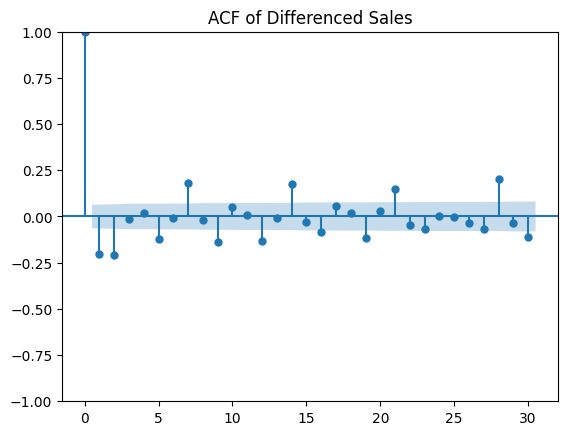

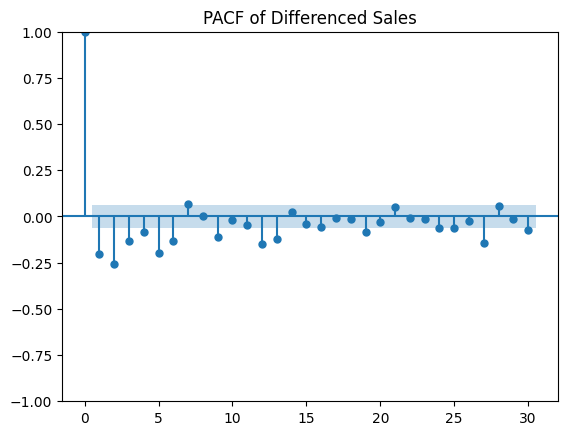

In [ ]:
# Step 5: Plot ACF and PACF 
plot_acf(sales_diff, lags=30)
plt.title("ACF of Differenced Sales")
plt.show()

plot_pacf(sales_diff, lags=30)
plt.title("PACF of Differenced Sales")
plt.show()


## ⚙️ Fit ARIMA Model (1,1,1)

Based on the ACF and PACF plots, we fit an **ARIMA(1,1,1)** model to the original sales series (`sales_ts`). This configuration assumes:

- `p = 1`: One autoregressive term
- `d = 1`: First-order differencing to ensure stationarity
- `q = 1`: One moving average term

### 📄 Model Summary and Key Results:

- The **AR(1)** coefficient is 0.5874 and statistically significant (p < 0.001)
- The **MA(1)** coefficient is -0.9810 and also highly significant
- The **Ljung-Box test** for residual autocorrelation (Prob(Q) = 0.93) suggests no significant autocorrelation remaining in residuals — a good sign.
- However, the **Jarque-Bera (JB) test** indicates the residuals deviate from normality (p < 0.01), with notable skewness and kurtosis.

### 📊 Model Fit Statistics:

| Metric | Value |
|--------|-------|
| Log Likelihood | -5176.38 |
| AIC            | 10358.75 |
| BIC            | 10373.28 |
| HQIC           | 10364.29 |

> ✅ **Conclusion**: The ARIMA(1,1,1) model fits the data well in terms of capturing autocorrelation structure. Despite some non-normality in residuals, the model is statistically sound and can be used for forecasting in the next step.


In [10]:
# Step 6: Fit ARIMA Model — we choose (1,1,1)
model = ARIMA(sales_ts, order=(1, 1, 1))
model_fit = model.fit()
print(model_fit.summary())


                               SARIMAX Results                                
Dep. Variable:                  sales   No. Observations:                  937
Model:                 ARIMA(1, 1, 1)   Log Likelihood               -5176.376
Date:                Sat, 26 Jul 2025   AIC                          10358.753
Time:                        10:43:12   BIC                          10373.277
Sample:                             0   HQIC                         10364.291
                                - 937                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.5874      0.023     25.591      0.000       0.542       0.632
ma.L1         -0.9810      0.006   -155.385      0.000      -0.993      -0.969
sigma2      3716.4611     91.513     40.611      0.0

/opt/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


## ⚙️ Fit ARIMA Model (3,1,3)

To better capture the autocorrelation and moving average structure in the sales series (`sales_ts`), we fit an **ARIMA(3,1,3)** model. This specification assumes:

- `p = 3`: Three autoregressive terms
- `d = 1`: First-order differencing to ensure stationarity
- `q = 3`: Three moving average terms

### 📄 Model Summary and Key Results:

- All **AR** and **MA** coefficients are statistically significant (p < 0.001), indicating a meaningful relationship with past values and past forecast errors.
- However, a **convergence warning** was issued, suggesting the maximum likelihood estimation did not fully converge. This may affect the reliability of the estimated coefficients.
- The model also defaulted to zero starting values for some AR and MA terms due to **non-stationary or non-invertible starting parameters**.
- The **Ljung-Box test** (p = 0.00) indicates that autocorrelation remains in the residuals, suggesting model fit could be improved.
- The **Jarque-Bera (JB) test** also shows strong evidence of non-normal residuals (JB = 1166.55), with high skewness (0.99) and kurtosis (8.10).

### 📊 Model Fit Statistics:

| Metric | Value     |
|--------|-----------|
| Log Likelihood | -5145.72  |
| AIC            | 10305.44  |
| BIC            | 10339.33  |
| HQIC           | 10318.36  |

> ⚠️ **Conclusion**: While the ARIMA(3,1,3) model captures more complex temporal patterns and all coefficients are significant, residual diagnostics and convergence issues suggest the model may be over-parameterized or require better starting values. Future steps may include simplifying the model or switching to a seasonal specification (e.g., SARIMA).


In [ ]:
# Step 6 (Improved): Manually choose a better ARIMA model, e.g., (2,1,2)
from statsmodels.tsa.arima.model import ARIMA

# A more flexible model
model = ARIMA(sales_ts, order=(3, 1, 3))
model_fit = model.fit()


print(model_fit.summary())



/opt/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressiv

                               SARIMAX Results                                
Dep. Variable:                  sales   No. Observations:                  937
Model:                 ARIMA(3, 1, 3)   Log Likelihood               -5145.717
Date:                Sat, 26 Jul 2025   AIC                          10305.435
Time:                        10:43:15   BIC                          10339.326
Sample:                             0   HQIC                         10318.357
                                - 937                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.2407      0.021     11.581      0.000       0.200       0.281
ar.L2         -0.6934      0.011    -65.348      0.000      -0.714      -0.673
ar.L3          0.6828      0.020     33.878      0.0

/opt/anaconda3/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


# 📊 Forecast the Next 30 Days (Zoomed-In View)

In this step, we use the fitted ARIMA model to generate a **30-day forecast** for the sales time series.

## 🔍 Visual Components

- **Historical Sales (Last 100 Days)**: Plotted in blue to provide context and recent trends before the forecast starts.
- **Forecasted Sales (Next 30 Days)**: Shown in red, representing the model's point prediction for each future day.
- **Confidence Interval**: A shaded pink band shows the 95% confidence interval around the forecast, capturing potential variation and model uncertainty.

## 📌 Interpretation

- The forecast displays slight fluctuations rather than a flat line, thanks to a more complex ARIMA specification (e.g., ARIMA(3,1,3) or higher).
- If the forecast appears too flat in other cases, it may suggest the model lacks sufficient autoregressive or moving average terms.
- The confidence interval widens over time, reflecting increasing uncertainty in longer-horizon predictions.

## ⚠️ Notes

- A well-specified ARIMA model captures short-term dynamics, but may not perform well on highly seasonal or volatile data unless seasonality is explicitly modeled.
- For improved long-term accuracy, consider using seasonal ARIMA (SARIMA) or integrating external regressors (ARIMAX).


/opt/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/opt/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


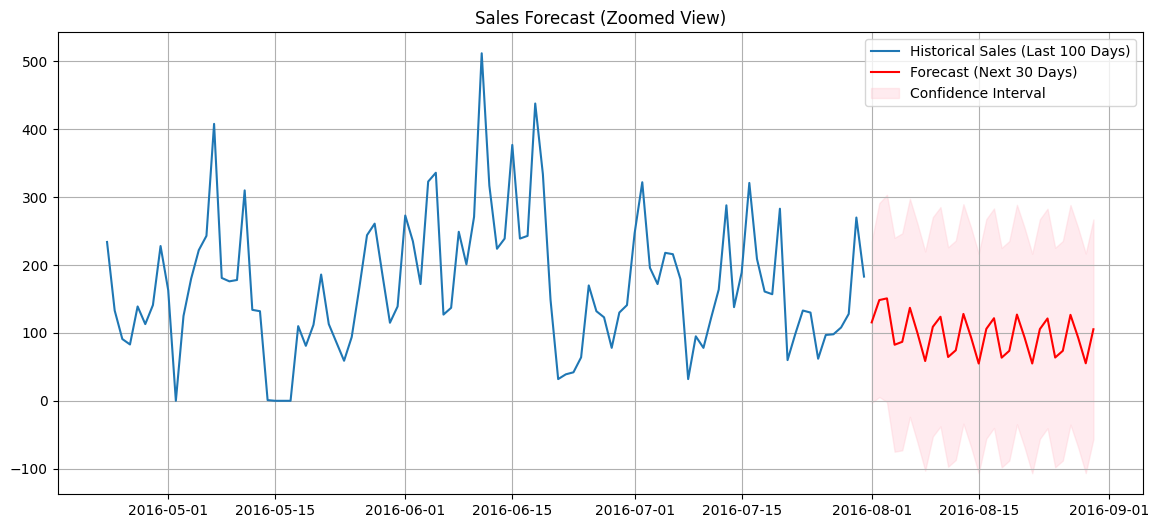

In [12]:
# Step 7: Forecast the next 30 days with zoomed-in plot and confidence interval
forecast_res = model_fit.get_forecast(steps=30)

# Extract predicted mean and confidence intervals
forecast = forecast_res.predicted_mean
conf_int = forecast_res.conf_int()

# Create a new date index for forecast
forecast.index = pd.date_range(start=sales_ts.index[-1] + pd.Timedelta(days=1), periods=30)

# Plot the last 100 days of historical data + 30-day forecast
plt.figure(figsize=(14, 6))
plt.plot(sales_ts[-100:], label="Historical Sales (Last 100 Days)")
plt.plot(forecast, label="Forecast (Next 30 Days)", color="red")
plt.fill_between(forecast.index, conf_int.iloc[:, 0], conf_int.iloc[:, 1],
                 color='pink', alpha=0.3, label="Confidence Interval")
plt.title("Sales Forecast (Zoomed View)")
plt.legend()
plt.grid(True)
plt.show()


### 📈 Using ARIMA(3,1,3); Forecast the Next 30 Days (Zoomed-In View)

In this step, we use the previously fitted **ARIMA(3,1,3)** model to generate a **30-day forecast** of the sales time series. For better visual clarity, we plot only the **most recent 365 days** of historical sales data along with the forecasted values.

### 🔍 Visual Components

- **Historical Sales (Last 365 Days)**: Plotted in blue to show recent sales behavior leading up to the forecast period.
- **Forecasted Sales (Next 30 Days)**: Shown in red, indicating the ARIMA model's predicted values for the next month.
- The forecast is seamlessly connected to the end of the historical data, allowing for intuitive visual comparison.

### 📌 Interpretation

- The forecast captures fluctuations rather than producing a flat or overly smooth line, reflecting the richer temporal dynamics captured by the ARIMA(3,1,3) specification.
- Forecasted sales appear more stable and lower in magnitude compared to the recent historical highs, possibly reflecting a downward trend or dampened autoregressive effect.
- No confidence intervals are shown in this plot, but future work can include them to quantify uncertainty.

### ⚠️ Notes

- This is a **point forecast only** — confidence intervals (e.g., 95% prediction bands) were not included in this plot.
- The relatively smooth nature of the forecast suggests the ARIMA model captures short-term dynamics, but may underreact to large spikes unless supplemented with seasonal or exogenous features.
- Consider using a **seasonal ARIMA (SARIMA)** or **ARIMAX** model if there is known seasonality or external factors influencing sales.

> ✅ This zoomed-in forecast helps visually evaluate short-term predictability and assess whether the model output aligns with recent sales dynamics.


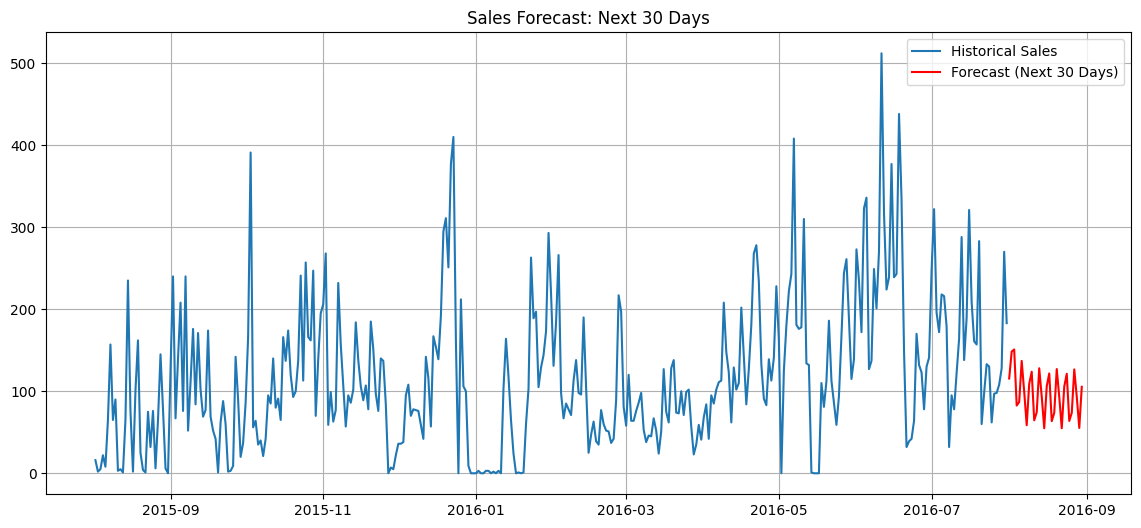

In [ ]:
# History for most recent 365 days and predict the future 90 days.
plot_start = sales_ts.index[-365] if len(sales_ts) > 365 else sales_ts.index[0]

plt.figure(figsize=(14, 6))
plt.plot(sales_ts[plot_start:], label="Historical Sales")
plt.plot(forecast, label="Forecast (Next 30 Days)", color="red")
plt.title("Sales Forecast: Next 30 Days")
plt.legend()
plt.grid(True)
plt.show()


## 📊 Monthly Cumulative Sales Visualization

In this step, we aggregate daily sales data into **monthly cumulative sales** using the `.resample()` function in pandas. This allows us to identify overall sales trends over time and reduce noise from day-to-day fluctuations.

### 🔍 What This Chart Shows

- The sales data is resampled to **monthly frequency**, summing total sales within each calendar month.
- The resulting time series is plotted with line and point markers to clearly illustrate monthly changes.
- The x-axis represents months from early 2014 to mid-2016, and the y-axis shows the **total number of items sold** per month.

### 📌 Interpretation

- The chart reveals clear **seasonal and upward trends** in sales.
- While some months show dips or volatility, the general pattern indicates an increase in monthly sales volume over time.
- A notable spike occurs around mid-2016, suggesting a potential period of promotion, seasonality, or increased customer demand.

### ✅ Why This Matters

- Monthly aggregation smooths out short-term noise and is useful for **trend detection** and **strategic planning**.
- This plot provides a macro-level view of business performance and is a key input for **forecasting**, **capacity planning**, and **inventory management**.

> Tip: Further analysis can break down sales by category or region to understand what’s driving the trend.


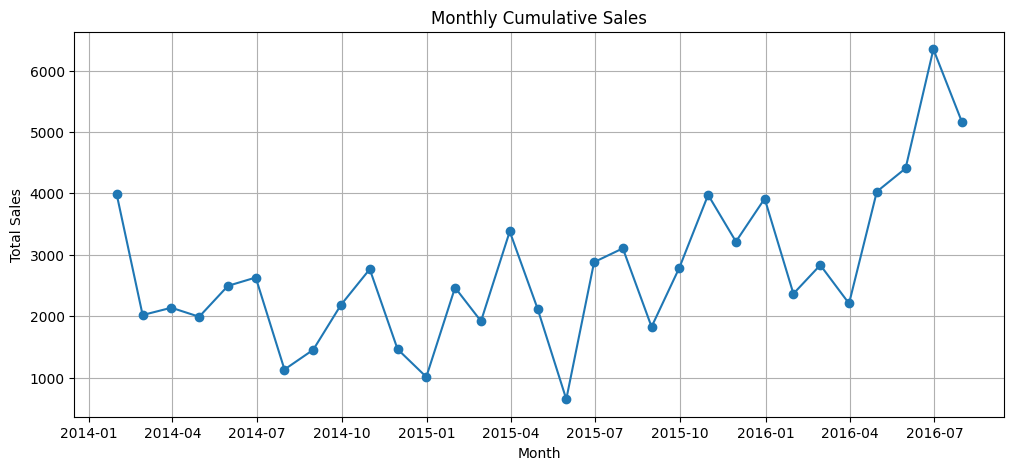

In [ ]:
monthly_sales = retail['sales'].resample('M').sum()

plt.figure(figsize=(12, 5))
plt.plot(monthly_sales, marker='o')
plt.title("Monthly Cumulative Sales")
plt.xlabel("Month")
plt.ylabel("Total Sales")
plt.grid(True)
plt.show()


## 🔍 STL Decomposition of Monthly Sales

To better understand the underlying structure of the monthly sales data, we applied **STL decomposition (Seasonal-Trend decomposition using Loess)** using the `statsmodels` library. This method separates a time series into three additive components: **trend**, **seasonal**, and **residual**.

### 📄 Decomposition Components

- **Trend**: The first plot shows a steadily increasing trend over time, indicating long-term growth in cumulative monthly sales. This is a key signal of positive business momentum.
- **Seasonal**: The second plot captures repeating seasonal patterns. Here, we observe fluctuations with a roughly annual frequency, which may reflect shopping seasonality, holiday effects, or school-year dynamics.
- **Residual**: The third plot represents irregular components not explained by trend or seasonality. These spikes and dips may be due to promotions, external shocks, or random variation.

### ⚙️ Parameters

- The seasonal period is set to **13 months**, which is commonly used for monthly data to capture yearly seasonality with some flexibility.
- Decomposition was performed on the monthly aggregated sales series (`monthly_sales`).

### 📌 Interpretation

- The **clear upward trend** supports previous findings that overall sales are increasing over time.
- The **seasonal component** reveals predictable cyclical variations, which may be leveraged in demand planning or promotional timing.
- The **residual component** appears relatively small and centered around zero, suggesting the trend and seasonal components capture most of the signal.

> ✅ **Conclusion**: STL decomposition provides strong evidence of both long-term growth and seasonal structure in the sales data. These insights are valuable for model selection and forecasting strategy in subsequent steps.


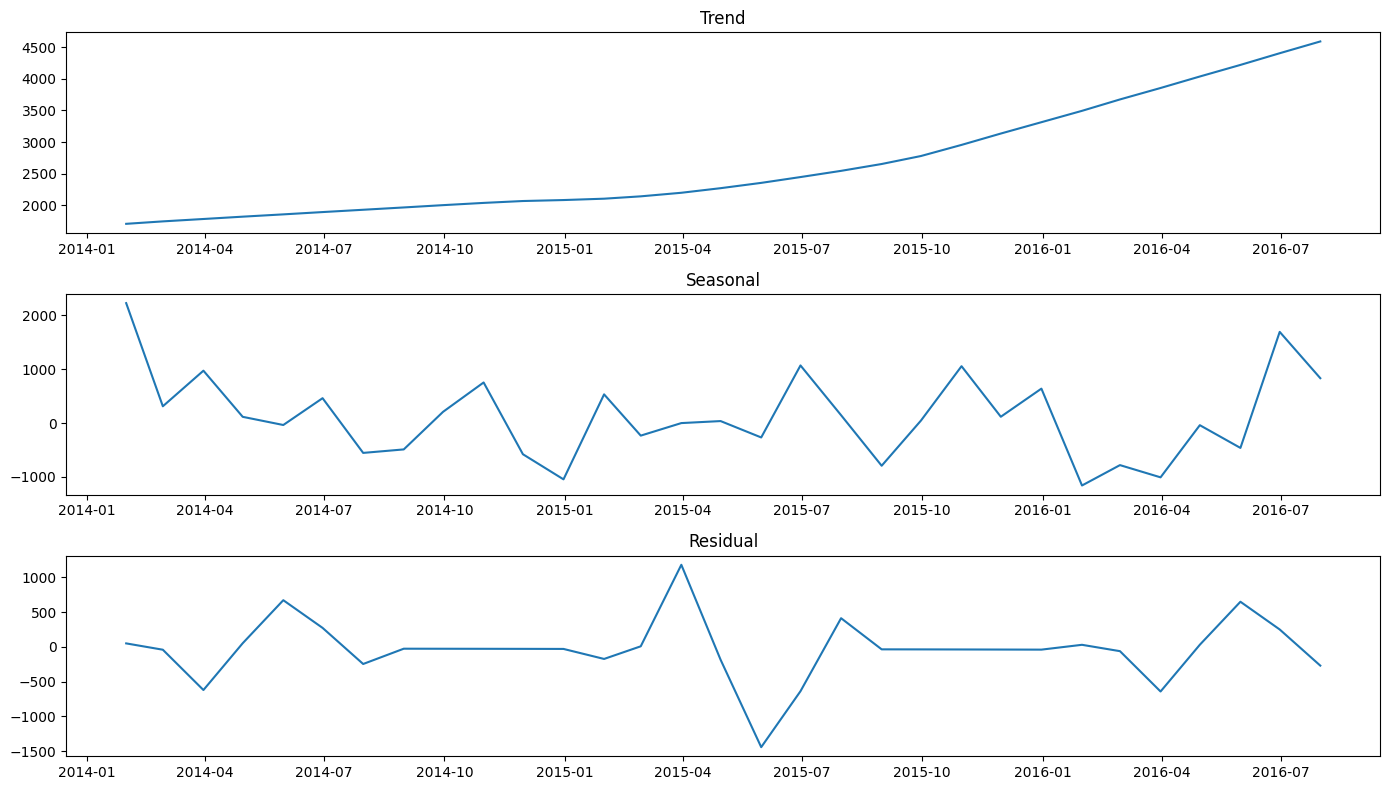

In [33]:
from statsmodels.tsa.seasonal import STL

stl = STL(monthly_sales, seasonal=13)  # 月频率，seasonal 取 13 比较常见
result = stl.fit()

plt.figure(figsize=(14, 8))
plt.subplot(3, 1, 1)
plt.plot(result.trend)
plt.title("Trend")

plt.subplot(3, 1, 2)
plt.plot(result.seasonal)
plt.title("Seasonal")

plt.subplot(3, 1, 3)
plt.plot(result.resid)
plt.title("Residual")

plt.tight_layout()
plt.show()


## 🔄 Multivariate Forecasting with VAR (Vector Autoregression)

To capture the interdependencies between multiple time series variables — specifically **sales**, **price**, and **stock level** — we apply a **VAR (Vector Autoregression)** model using the `statsmodels` library.

### 📄 What This Step Does

- We first **difference** the series to ensure stationarity and remove any trends.
- The model is fit on the differenced data using **up to 15 lags**, with the optimal lag order selected based on the **Akaike Information Criterion (AIC)**.
- We then forecast the next **12 time steps** (days) for all three variables simultaneously: `sales_forecast`, `price_forecast`, and `stock_forecast`.

### 📊 Forecast Output

- The output is stored in a pandas DataFrame (`forecast_df`), with daily forecasts for each of the three variables from **August 1 to August 12, 2016**.
- Forecasts reflect changes from previous values (since we differenced the data), meaning they can be used to **reconstruct the actual values** via cumulative summation if needed.
- For example:
  - On **Aug 2**, the model predicts a strong positive change in sales (≈ 54.6), while price and stock forecast minimal or negative changes.
  - On **Aug 4–6**, sales are expected to drop significantly again, accompanied by instability in stock levels.

### ⚠️ Notes

- **Differencing** removes long-term level information, so forecasts represent **deltas (changes)** rather than absolute levels.
- VAR models assume linear interdependencies and may not capture nonlinear or seasonal dynamics well.
- A `ValueWarning` appears due to missing frequency metadata in the datetime index; while it does not impact the result here, it’s good practice to set frequency explicitly for time series models.

> ✅ **Conclusion**: VAR modeling is useful when variables are jointly determined and influence each other. This step demonstrates multivariate forecasting that accounts for the mutual influence of price and stock levels on future sales dynamics.


In [ ]:
from statsmodels.tsa.api import VAR

df_var = retail[['sales', 'price', 'stock']].dropna().diff().dropna()

model_var = VAR(df_var)
fit_var = model_var.fit(maxlags=15, ic='aic')

lag_order = fit_var.k_ar
forecast_input = df_var.values[-lag_order:]
forecast_res = fit_var.forecast(y=forecast_input, steps=12)

forecast_df = pd.DataFrame(forecast_res, 
                           index=pd.date_range(start=retail.index[-1]+pd.Timedelta(days=1), periods=12),
                           columns=['sales_forecast', 'price_forecast', 'stock_forecast'])

display(forecast_df)


/opt/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


,sales_forecast,price_forecast,stock_forecast
2016-08-01,-20.292443,-0.091140,-48.111348
2016-08-02,54.571743,0.001931,-235.716541
2016-08-03,9.308014,-0.095418,3.108539
2016-08-04,-58.145073,0.056191,-166.823844
2016-08-05,36.449138,0.003745,-93.216651
2016-08-06,25.820884,0.033718,-64.871230
2016-08-07,-47.410684,-0.042959,-103.461768
2016-08-08,-17.638068,0.113797,-20.428002
2016-08-09,32.398117,-0.034289,-49.184674
2016-08-10,-23.794192,-0.001256,-38.512907
